# Code

In [1]:
its_jupyter_notebook = True

In [2]:
import pandas as pd
import time
import os
import re
import matplotlib.pyplot as plt
import time
import numpy as np
import random
import sys
import torch
import pickle
from pathlib import Path
from torch.utils.data import DataLoader
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!
sys.path.insert(0, '..')
from tqdm.notebook import tqdm
import seaborn as sns
import util.misc as utils
from dataset.data import (
    RNADataset,
    RNADatasetNT,
    RNADatasetNT500,
    EasyPosAugment,
    InteractionSelectionPolicy,
    EasyNegAugment,
    HardPosAugment,
    HardNegAugment,
    SmartNegAugment,
    HFDataset,
    HFDataLoader, 
    create_augment_list,
    plot_sample,
    seed_everything,
    clean_nt_dataframes_before_class_input,
)
from train_binary_cl import seed_worker, obtain_train_dataset, obtain_val_dataset, undersample_df, obtain_policies_object, obtain_dataset_object
from config import *

<class 'transformers.tokenization_dna.DNATokenizer'>


In [3]:
EASY_PRETRAINING = False
FINETUNING = True
TRAIN_HQ = False
SPECIE = 'human'

scaling_factor = 5
min_n_groups_train = 5
max_n_groups_train = 80
min_n_groups_val = 80
max_n_groups_val = 80

# Esecuzione data loader train

In [4]:
if EASY_PRETRAINING:
    df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_easy.csv'))
    df_genes_nt = pd.read_csv(os.path.join(metadata_dir, f'df_genes_nt_easy.csv'))
    subset_train_nt = os.path.join(rna_rna_files_dir, f"gene_pairs_training_nt_easy.txt")
else:
    if TRAIN_HQ:
        df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_HQ.csv'))
        df_genes_nt = pd.read_csv(os.path.join(metadata_dir, f'df_genes_nt_HQ.csv'))
        df_nt, df_genes_nt = clean_nt_dataframes_before_class_input(df_nt, df_genes_nt)
        subset_train_nt = os.path.join(rna_rna_files_dir, 'gene_pairs_training_nt_HQ.txt')
    else:
        df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))
        df_genes_nt = pd.read_csv(os.path.join(metadata_dir, f'df_genes_nt.csv'))
        df_nt, df_genes_nt = clean_nt_dataframes_before_class_input(df_nt, df_genes_nt)
        if FINETUNING:
            subset_train_nt = os.path.join(rna_rna_files_dir, f"gene_pairs_train_val_fine_tuning_nt.txt")
        else:
            subset_train_nt = os.path.join(rna_rna_files_dir, f"gene_pairs_training_nt.txt")

with open(subset_train_nt, "rb") as fp:  # Unpickling
    list_train = pickle.load(fp)

if SPECIE in ['human', 'mouse']:
    paris = pd.read_csv(os.path.join(processed_files_dir, f'paris.csv'))
    couples_to_keep = set(paris[paris.specie == SPECIE].couples)
    df_nt = df_nt[df_nt.couples_id.isin(couples_to_keep)]
    
vc_train = df_nt[df_nt.couples.isin(list_train)].interacting.value_counts()
assert vc_train[False]>vc_train[True]
unbalance_factor = 1 - (vc_train[False] - vc_train[True]) / vc_train[False]

if EASY_PRETRAINING:
    pos_multipliers = {15:0.2, 
            25:0.3,
            50:0.2, 
            100:0.23, 
            10_000_000: 0.07}

    neg_multipliers = {15:0.05, 
                    28:0.15,

                    40:0.08,
                    50:0.05,
                    60:0.1,

                    80:0.03,
                    90:0.03,
                    100:0.05,

                    110:0.05,

                    120:0.1,

                    140:0.05,
                    160:0.03,
                    180:0.03,
                    200:0.03,
                    220:0.02,
                    240:0.01,
                    260:0.01,

                    10_000_000: 0.1}

else:
    pos_multipliers = {15:0.2, 
                   25:0.3,
                   50:0.2, 
                   100:0.23,
                   100_000_000:0.07}
    neg_multipliers = pos_multipliers

/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (1,2,16,17,18,20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
# policies_train = [
#     EasyPosAugment(
#         per_sample=0.5,
#         interaction_selection=InteractionSelectionPolicy.LARGEST,
#         width_multipliers=pos_multipliers,
#         height_multipliers=pos_multipliers,
#     ),  
#     SmartNegAugment(
#         per_sample=unbalance_factor * 0.5,
#         interaction_selection=InteractionSelectionPolicy.LARGEST,
#         width_multipliers=neg_multipliers,
#         height_multipliers=neg_multipliers,
#     ),
# ]

per_sample_p = 0.25

proportion_sn = 0.55
proportion_hn = 0.35
proportion_en = 0.1

sn_per_sample = unbalance_factor * (per_sample_p) * proportion_sn
hn_per_sample = (per_sample_p) * proportion_hn
en_per_sample = unbalance_factor * (per_sample_p) * proportion_en


neg_windows = {(280, 800): 0.4, (800, 1_500): 0.15, (1_500, 2_000): 0.1, (2_000, 2_300): 0.1, (2_300, 5_969): 0.15, (5_969, 5_970): 0.1}

policies_train = obtain_policies_object(per_sample_p, sn_per_sample, hn_per_sample, en_per_sample, pos_multipliers, neg_multipliers, neg_windows)

In [6]:
np.sum(list(neg_multipliers.values()))

1.0

In [7]:
dataset_paris = RNADatasetNT(
            gene2info=df_genes_nt,
            interactions=df_nt,
            subset_file=subset_train_nt,
            augment_policies=policies_train,
            data_dir = os.path.join(embedding_dir, '32'),
            scaling_factor = scaling_factor,
            min_n_groups = min_n_groups_train,
            max_n_groups = max_n_groups_train,
)

In [24]:
n_epochs = 5
neg_len_1 = []
pos_len_1 = []
neg_len_2 = []
pos_len_2 = []
matrix_area_neg = []
matrix_area_pos = []

all_couples_id = []

for epoch in tqdm(range(n_epochs)):
    dataset_train = RNADatasetNT(
            gene2info=df_genes_nt,
            interactions=df_nt,
            subset_file=subset_train_nt,
            augment_policies=policies_train,
            data_dir = os.path.join(embedding_dir, '32'),
            scaling_factor = scaling_factor,
            min_n_groups = min_n_groups_train,
            max_n_groups = max_n_groups_train,
    )
    for sample in tqdm(dataset_train, total=len(dataset_train)):
        box = sample.bbox
        if sample.interacting:
            pos_len_1.append(box.x2-box.x1)
            pos_len_2.append(box.y2-box.y1)
            matrix_area_pos.append((box.x2-box.x1)*(box.y2-box.y1))
        else:
            neg_len_1.append(box.x2-box.x1)
            neg_len_2.append(box.y2-box.y1)
            matrix_area_neg.append((box.x2-box.x1)*(box.y2-box.y1))
            
        g1 = re.search('(.*)_(.*)_(.*)', sample.gene1).group(1)
        g2 = re.search('(.*)_(.*)_(.*)', sample.gene2).group(1)
        all_couples_id.append(g1 + '_' + g2)
        all_couples_id.append(g2 + '_' + g1)
            
neg_len = neg_len_1+neg_len_2
pos_len = pos_len_1+pos_len_2
label_n = ['n' for i in range(len(neg_len))]
label_p = ['p' for i in range(len(pos_len))]
label = label_n + label_p
length = neg_len + pos_len
df_len = pd.DataFrame({'label':label, 'length':length})

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/34808 [00:00<?, ?it/s]

  0%|          | 0/35348 [00:00<?, ?it/s]

  0%|          | 0/34799 [00:00<?, ?it/s]

  0%|          | 0/34639 [00:00<?, ?it/s]

  0%|          | 0/35177 [00:00<?, ?it/s]

In [25]:
# plot_sample(sample, plot_interaction_negatives=True)

In [26]:
df_len.label.value_counts()

n    174984
p    174558
Name: label, dtype: int64

In [27]:
df_len.sort_values('length').head(500).label.value_counts()

n    465
p     35
Name: label, dtype: int64

In [28]:
(float(df_len.sort_values('length').quantile(0.2))/6)/80

0.90625

In [29]:
(float(df_len.sort_values('length').quantile(0.5))/6)/80

1.7708333333333333

In [30]:
#balance set
assert abs(df_len.label.value_counts().n/df_len.shape[0] - 0.5) < 0.05

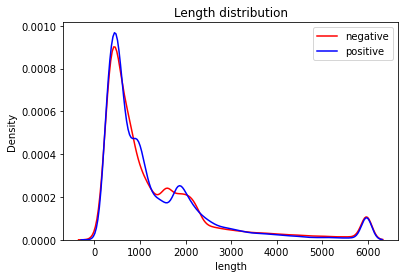

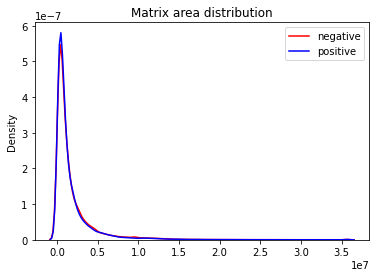

In [31]:
sns.kdeplot(df_len[df_len.label == 'n'].length, color = 'red', label = 'negative')
sns.kdeplot(df_len[df_len.label == 'p'].length, color = 'blue', label = 'positive')
plt.title(f'Length distribution')
plt.legend()
plt.show()
sns.kdeplot(matrix_area_neg, color = 'red', label = 'negative')
sns.kdeplot(matrix_area_pos, color = 'blue', label = 'positive')
plt.title(f'Matrix area distribution')
plt.legend()
plt.show()

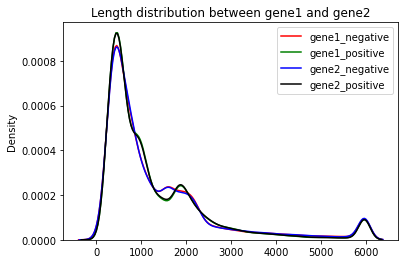

In [32]:
sns.kdeplot(neg_len_1, color = 'red', label = 'gene1_negative')
sns.kdeplot(pos_len_1, color = 'green', label = 'gene1_positive')
sns.kdeplot(neg_len_2, color = 'blue', label = 'gene2_negative')
sns.kdeplot(pos_len_2, color = 'black', label = 'gene2_positive')
plt.title(f'Length distribution between gene1 and gene2')
plt.legend()
plt.show()

In [33]:
small_l = df_len.length.quantile(0.1)
print(df_len[df_len['length'] < small_l].label.value_counts())
print('\n')
big_l = df_len.length.quantile(0.7)
print(df_len[df_len['length'] > big_l].label.value_counts())

p    17756
n    17169
Name: label, dtype: int64


n    53939
p    50719
Name: label, dtype: int64


# Validation set 

In [285]:
EASY_PRETRAINING = False
SPECIE = 'human'

In [286]:
if SPECIE in ['human', 'mouse']:
    paris = pd.read_csv(os.path.join(processed_files_dir, f'paris.csv'))
    couples_to_keep = set(paris[paris.specie == SPECIE].couples)

if EASY_PRETRAINING:
    df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_easy.csv'))
    df_genes_nt = pd.read_csv(os.path.join(metadata_dir, f'df_genes_nt_easy.csv'))
    subset_val_nt = os.path.join(rna_rna_files_dir, f"gene_pairs_val_sampled_nt_easy.txt")
    if SPECIE in ['human', 'mouse']:
        df_nt = df_nt[df_nt.couples_id.isin(couples_to_keep)]
else:
    df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_HQ.csv'))
    df_genes_nt = pd.read_csv(os.path.join(metadata_dir, f'df_genes_nt_HQ.csv'))
    if FINETUNING:
        subset_val_nt = os.path.join(rna_rna_files_dir, f"gene_pairs_test_sampled_nt_HQ.txt") # gene_pairs_test_sampled_nt.txt it is also HQ
        df500 = pd.read_csv(os.path.join(metadata_dir, f'test500.csv'))
    else:
        subset_val_nt = os.path.join(rna_rna_files_dir, f"gene_pairs_val_sampled_nt_HQ.txt") # gene_pairs_val_sampled_nt.txt it is also HQ
        df500 = pd.read_csv(os.path.join(metadata_dir, f'val500.csv'))

    with open(subset_val_nt, "rb") as fp:  # Unpickling
        list_val = pickle.load(fp)
        
    if SPECIE in ['human', 'mouse']:
        df_nt = df_nt[df_nt.couples_id.isin(couples_to_keep)]
    elif SPECIE == 'all':
        assert df500.shape[0] == df_nt[['couples', 'interacting', 'policy']].merge(df500, on = 'couples').shape[0]
        
    df500 = df_nt[['couples', 'interacting']].merge(df500, on = 'couples')
    df500 = df500[df500.couples.isin(list_val)] # in questo modo ho quasi bilanciato del tutto, ma per avere un bilanciamento al 100% devo fare undersampling
    df500 = undersample_df(df500) #bilanciamento al 100%.

if EASY_PRETRAINING:
    pos_multipliers = {25:0.7, 50:0.2, 100:0.1}
    neg_multipliers = {33:0.3, 45:0.1, 55:0.1, 65:0.1,
                       80:0.05, 90:0.05, 100:0.05,
                       120:0.05, 150:0.02, 160:0.02,
                       170:0.02, 180:0.02, 190:0.02,
                       200:0.02, 210:0.02, 220:0.02}

    policies_val = [
        EasyPosAugment(
            per_sample=1,
            interaction_selection=InteractionSelectionPolicy.LARGEST,
            width_multipliers=pos_multipliers,
            height_multipliers=pos_multipliers,
        ),  
        SmartNegAugment(
            per_sample=1, # unbalance_factor
            interaction_selection=InteractionSelectionPolicy.LARGEST,
            width_multipliers=neg_multipliers,
            height_multipliers=neg_multipliers,
        ),
    ]

    dataset_val = RNADatasetNT(
        gene2info=df_genes_nt,
        interactions=df_nt,
        subset_file=subset_val_nt,
        augment_policies=policies_val,
        data_dir = os.path.join(embedding_dir, '32'),
        scaling_factor = scaling_factor,
        min_n_groups = min_n_groups_val,
        max_n_groups = max_n_groups_val,
    )

else:

    df500 = df500.sample(frac=1, random_state=23).reset_index(drop = True)
    assert df500.shape[0]>0

    dataset_val = RNADatasetNT500(
        df = df500,
        data_dir = os.path.join(embedding_dir, '32'),
        scaling_factor = scaling_factor,
        min_n_groups = min_n_groups_val,
        max_n_groups = max_n_groups_val,
    )
sampler_val = torch.utils.data.SequentialSampler(dataset_val)

/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (1,2,16,17,18,20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [287]:
np.sum(list(neg_multipliers.values()))

0.99

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9266 [00:00<?, ?it/s]

  0%|          | 0/9266 [00:00<?, ?it/s]

  0%|          | 0/9266 [00:00<?, ?it/s]

  0%|          | 0/9266 [00:00<?, ?it/s]

  0%|          | 0/9266 [00:00<?, ?it/s]

  0%|          | 0/9266 [00:00<?, ?it/s]

  0%|          | 0/9266 [00:00<?, ?it/s]

  0%|          | 0/9266 [00:00<?, ?it/s]

  0%|          | 0/9266 [00:00<?, ?it/s]

  0%|          | 0/9266 [00:00<?, ?it/s]

median: 500.0


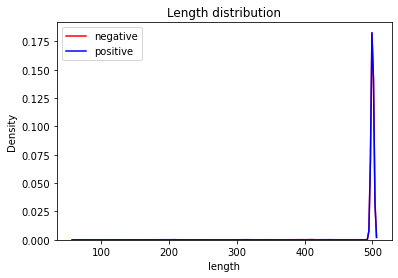

In [288]:
neg_len_1 = []
pos_len_1 = []
neg_len_2 = []
pos_len_2 = []
matrix_area_neg = []
matrix_area_pos = []

for epoch in tqdm(range(n_epochs)):
    for sample in tqdm(dataset_val, total=len(dataset_val)):
        box = sample.bbox
        if sample.interacting:
            pos_len_1.append(box.x2-box.x1)
            pos_len_2.append(box.y2-box.y1)
            matrix_area_pos.append((box.x2-box.x1)*(box.y2-box.y1))
        else:
            neg_len_1.append(box.x2-box.x1)
            neg_len_2.append(box.y2-box.y1)
            matrix_area_neg.append((box.x2-box.x1)*(box.y2-box.y1))
        
neg_len = neg_len_1+neg_len_2
pos_len = pos_len_1+pos_len_2
label_n = ['n' for i in range(len(neg_len))]
label_p = ['p' for i in range(len(pos_len))]
label = label_n + label_p
length = neg_len + pos_len
df_len = pd.DataFrame({'label':label, 'length':length})

print('median:', df_len.length.median())

sns.kdeplot(df_len[df_len.label == 'n'].length, color = 'red', label = 'negative')
sns.kdeplot(df_len[df_len.label == 'p'].length, color = 'blue', label = 'positive')
plt.title(f'Length distribution')
plt.legend()

# Esecuzione data loader external dataset

In [289]:
dataset = 'ricseq'

df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_{dataset}.csv'))
df_genes_nt = pd.read_csv(os.path.join(metadata_dir, f'df_genes_nt_{dataset}.csv'))
df_nt, df_genes_nt = clean_nt_dataframes_before_class_input(df_nt, df_genes_nt)
data_dir = os.path.join(rna_rna_files_dir, f'{dataset}')
file_training = os.path.join(data_dir, 'gene_pairs_training.txt')
with open(file_training, "rb") as fp:   # Unpickling
    train_couples = pickle.load(fp)
    
file_test = os.path.join(data_dir, 'gene_pairs_test.txt')
with open(file_test, "rb") as fp:   # Unpickling
    test_couples = pickle.load(fp)
    
train_nt = df_nt[df_nt.couples_id.isin(train_couples)].reset_index(drop = True)
test_nt = df_nt[df_nt.couples_id.isin(test_couples)].reset_index(drop = True)

In [290]:
scaling_factor = 5

if dataset == 'splash':
    pos_multipliers = {2:0.7, 8:0.1, 15:0.1, 50:0.1, 100:0.1}
    neg_multipliers = {7:0.5, 15:0.3, 50:0.15, 100:0.15}

elif dataset == 'mario':
    pos_multipliers = {5:0.7, 15:0.2, 50:0.1, 100:0.1}
    neg_multipliers = {5:0.1, 6:0.35, 15:0.2, 50:0.15, 100:0.2}

elif dataset == 'ricseq':
    pos_multipliers = {3:0.8, 40:0.15, 100:0.05}
    neg_multipliers = {6:0.73, 70:0.13, 100:0.13}

vc_train = train_nt.interacting.value_counts()
if vc_train[False]>vc_train[True]:
    unbalance_factor = 1 - (vc_train[False] - vc_train[True]) / vc_train[False]
    policies_train = obtain_policies_object(0.25, 0.25*unbalance_factor, pos_multipliers, neg_multipliers)
elif vc_train[False]<vc_train[True]:
    unbalance_factor = 1 - (vc_train[True] - vc_train[False]) / vc_train[True]
    policies_train = obtain_policies_object(0.25*unbalance_factor, 0.25, pos_multipliers, neg_multipliers)
elif vc_train[True]==vc_train[True]:
    unbalance_factor = 1

In [291]:
if dataset == 'ricseq':
    dataset_ricseq = obtain_dataset_object(policies_train, df_genes_nt, train_nt, '', scaling_factor, min_n_groups_train, max_n_groups_train)
elif dataset == 'splash':
    dataset_splash = obtain_dataset_object(policies_train, df_genes_nt, train_nt, '', scaling_factor, min_n_groups_train, max_n_groups_train)

In [292]:
n_epochs = 50
neg_len_1 = []
pos_len_1 = []
neg_len_2 = []
pos_len_2 = []
matrix_area_neg = []
matrix_area_pos = []

all_couples_id = []

for epoch in tqdm(range(n_epochs)):
    dataset_train = obtain_dataset_object(policies_train, df_genes_nt, train_nt, '', scaling_factor, min_n_groups_train, max_n_groups_train)
    for sample in dataset_train:
        box = sample.bbox
        if sample.interacting:
            pos_len_1.append(box.x2-box.x1)
            pos_len_2.append(box.y2-box.y1)
            matrix_area_pos.append((box.x2-box.x1)*(box.y2-box.y1))
        else:
            neg_len_1.append(box.x2-box.x1)
            neg_len_2.append(box.y2-box.y1)
            matrix_area_neg.append((box.x2-box.x1)*(box.y2-box.y1))
            
        g1 = re.search('(.*)_(.*)_(.*)', sample.gene1).group(1)
        g2 = re.search('(.*)_(.*)_(.*)', sample.gene2).group(1)
        all_couples_id.append(g1 + '_' + g2)
        all_couples_id.append(g2 + '_' + g1)
        
neg_len = neg_len_1+neg_len_2
pos_len = pos_len_1+pos_len_2
label_n = ['n' for i in range(len(neg_len))]
label_p = ['p' for i in range(len(pos_len))]
label = label_n + label_p
length = neg_len + pos_len
df_len = pd.DataFrame({'label':label, 'length':length})

  0%|          | 0/50 [00:00<?, ?it/s]

In [293]:
print(len(set(train_couples)))
print(len(set(test_couples)))
print(len(set(all_couples_id)))
print('\n')
print(len(set(all_couples_id).intersection(train_couples)))
print(len(set(all_couples_id).intersection(test_couples)))
print('\n')
print(len(set(train_couples) - set(all_couples_id)))
print(len(set(test_couples) - set(all_couples_id)))

11938
5120
38040


0
0


11938
5120


In [294]:
df_len.label.value_counts()

n    159504
p    159178
Name: label, dtype: int64

In [295]:
df_len.sort_values('length').head(500).label.value_counts()

p    468
n     32
Name: label, dtype: int64

In [296]:
#balance set
assert abs(df_len.label.value_counts().n/df_len.shape[0] - 0.5) < 0.05

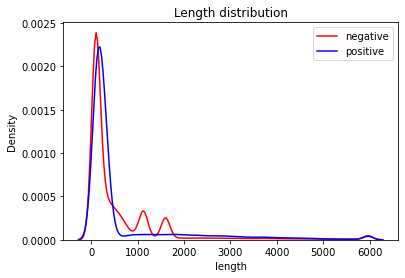

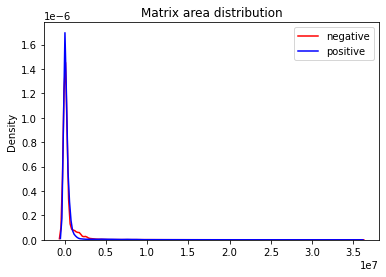

In [297]:
sns.kdeplot(df_len[df_len.label == 'n'].length, color = 'red', label = 'negative')
sns.kdeplot(df_len[df_len.label == 'p'].length, color = 'blue', label = 'positive')
plt.title(f'Length distribution')
plt.legend()
plt.show()
sns.kdeplot(matrix_area_neg, color = 'red', label = 'negative')
sns.kdeplot(matrix_area_pos, color = 'blue', label = 'positive')
plt.title(f'Matrix area distribution')
plt.legend()
plt.show()

### Validation

In [170]:
dataset = 'mario'

In [150]:
df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_{dataset}.csv'))
data_dir = os.path.join(rna_rna_files_dir, f'{dataset}')

file_test = os.path.join(data_dir, 'gene_pairs_test.txt')
with open(file_test, "rb") as fp:   # Unpickling
    test_couples = pickle.load(fp)

df500 = pd.read_csv(os.path.join(metadata_dir, f'{dataset}500.csv'))
assert df500.shape[0] == df_nt[['couples', 'couples_id', 'interacting', 'policy']].merge(df500, on = 'couples').shape[0]
df500 = df_nt[['couples', 'interacting', 'policy', 'couples_id']].merge(df500, on = 'couples')
df500 = df500[df500.couples_id.isin(test_couples)]
df500 = df500[df500.policy.isin(['easypos', 'smartneg'])]
df500 = undersample_df(df500)

df500 = df500.sample(frac=1, random_state=23).reset_index(drop = True)
assert df500.shape[0]>0

dataset_val = RNADatasetNT500(
    df = df500,
    data_dir = os.path.join(embedding_dir, '32'),
    scaling_factor = scaling_factor,
    min_n_groups = min_n_groups_val,
    max_n_groups = max_n_groups_val,
)
sampler_val = torch.utils.data.SequentialSampler(dataset_val)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/592 [00:00<?, ?it/s]

  0%|          | 0/592 [00:00<?, ?it/s]

  0%|          | 0/592 [00:00<?, ?it/s]

  0%|          | 0/592 [00:00<?, ?it/s]

  0%|          | 0/592 [00:00<?, ?it/s]

  0%|          | 0/592 [00:00<?, ?it/s]

  0%|          | 0/592 [00:00<?, ?it/s]

  0%|          | 0/592 [00:00<?, ?it/s]

  0%|          | 0/592 [00:00<?, ?it/s]

  0%|          | 0/592 [00:00<?, ?it/s]

median: 500.0


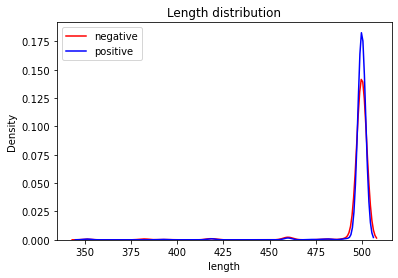

In [151]:
n_epochs = 10
neg_len_1 = []
pos_len_1 = []
neg_len_2 = []
pos_len_2 = []
matrix_area_neg = []
matrix_area_pos = []

for epoch in tqdm(range(n_epochs)):
    for sample in tqdm(dataset_val, total=len(dataset_val)):
        box = sample.bbox
        if sample.interacting:
            pos_len_1.append(box.x2-box.x1)
            pos_len_2.append(box.y2-box.y1)
            matrix_area_pos.append((box.x2-box.x1)*(box.y2-box.y1))
        else:
            neg_len_1.append(box.x2-box.x1)
            neg_len_2.append(box.y2-box.y1)
            matrix_area_neg.append((box.x2-box.x1)*(box.y2-box.y1))
        
neg_len = neg_len_1+neg_len_2
pos_len = pos_len_1+pos_len_2
label_n = ['n' for i in range(len(neg_len))]
label_p = ['p' for i in range(len(pos_len))]
label = label_n + label_p
length = neg_len + pos_len
df_len = pd.DataFrame({'label':label, 'length':length})

assert abs(df_len.label.value_counts().n/df_len.shape[0] - 0.5) < 0.05

print('median:', df_len.length.median())

sns.kdeplot(df_len[df_len.label == 'n'].length, color = 'red', label = 'negative')
sns.kdeplot(df_len[df_len.label == 'p'].length, color = 'blue', label = 'positive')
plt.title(f'Length distribution')
plt.legend()

# Combined dataset 1

In [4]:
import torch
from torch.utils.data import Dataset, ConcatDataset, DataLoader

# Custom dataset class to undersample the first two datasets
class UndersampledDataset(Dataset):
    def __init__(self, datasets):
        self.datasets = datasets
        self.length = min(len(dataset) for dataset in datasets)

    def __len__(self):
        return self.length * len(self.datasets)

    def __getitem__(self, index):
        dataset_idx = index // self.length
        sample_idx = index % self.length
        return self.datasets[dataset_idx][sample_idx]

In [ ]:
n_epochs = 10
batch_size = 32

for epoch in tqdm(range(n_epochs)):

    # Create UndersampledDataset with the concatenated dataset
    undersampled_dataset = UndersampledDataset([dataset_ricseq, dataset_splash, dataset_paris])
    undersampled_dataset = UndersampledDataset([dataset_splash, dataset_paris])
    # Create DataLoader using the undersampled dataset
    custom_data_loader = DataLoader(undersampled_dataset, batch_size=batch_size, shuffle=True, collate_fn=utils.collate_fn_nt3)

    neg_len_1 = []
    pos_len_1 = []
    neg_len_2 = []
    pos_len_2 = []
    matrix_area_neg = []
    matrix_area_pos = []

    for s, targets in custom_data_loader: #tqdm(custom_data_loader, total = len(custom_data_loader)):
        for sample in targets:
            box = sample['bbox']
            if sample['interacting']==1:
                pos_len_1.append(box.x2-box.x1)
                pos_len_2.append(box.y2-box.y1)
                matrix_area_pos.append((box.x2-box.x1)*(box.y2-box.y1))
            else:
                neg_len_1.append(box.x2-box.x1)
                neg_len_2.append(box.y2-box.y1)
                matrix_area_neg.append((box.x2-box.x1)*(box.y2-box.y1))

neg_len = neg_len_1+neg_len_2
pos_len = pos_len_1+pos_len_2
label_n = ['n' for i in range(len(neg_len))]
label_p = ['p' for i in range(len(pos_len))]
label = label_n + label_p
length = neg_len + pos_len
df_len = pd.DataFrame({'label':label, 'length':length})

In [307]:
len(neg_len)/2

360.0

In [308]:
len(pos_len)/2

372.0

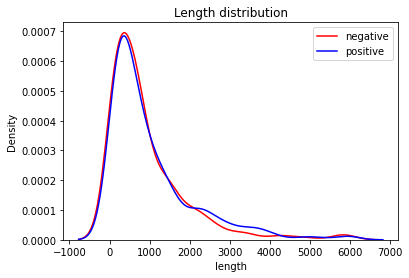

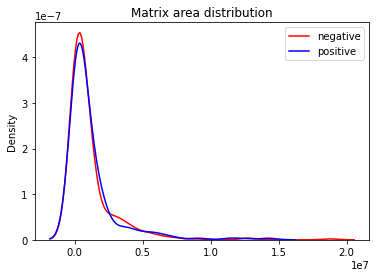

In [309]:
sns.kdeplot(df_len[df_len.label == 'n'].length, color = 'red', label = 'negative')
sns.kdeplot(df_len[df_len.label == 'p'].length, color = 'blue', label = 'positive')
plt.title(f'Length distribution')
plt.legend()
plt.show()
sns.kdeplot(matrix_area_neg, color = 'red', label = 'negative')
sns.kdeplot(matrix_area_pos, color = 'blue', label = 'positive')
plt.title(f'Matrix area distribution')
plt.legend()
plt.show()

# Combined dataset 2

In [6]:
dataset_splash, policies_splash = obtain_train_dataset('splash', False, False, True, 5, 100, 'human')
dataset_paris, policies_paris = obtain_train_dataset('paris', False, False, True,5, 100, 'human')

/data01/giorgio/RNARNA-NT/src/train_binary_cl.py:316: DtypeWarning: Columns (1,2,16,17,18,20) have mixed types.Specify dtype option on import or set low_memory=False.
  dataset_train, policies_train = obtain_train_dataset_paris(easy_pretraining, train_hq, finetuning, min_n_groups_train, max_n_groups_train, specie, scaling_factor)


In [7]:
import torch
from torch.utils.data import Dataset, ConcatDataset, DataLoader

class MergedDataset(Dataset):
    def __init__(self, datasets):
        self.datasets = datasets
        self.lengths = [len(dataset) for dataset in datasets]
        self.total_length = sum(self.lengths)

    def __len__(self):
        return self.total_length

    def __getitem__(self, index):
        for i, length in enumerate(self.lengths):
            if index < length:
                return self.datasets[i][index]
            index -= length

In [ ]:
n_epochs = 10
batch_size = 32

for epoch in tqdm(range(n_epochs)):

    # Create UndersampledDataset with the concatenated dataset
    undersampled_dataset = MergedDataset([dataset_splash, dataset_paris])
    # Create DataLoader using the undersampled dataset
    custom_data_loader = DataLoader(undersampled_dataset, batch_size=batch_size, shuffle=True, collate_fn=utils.collate_fn_nt3)

    neg_len_1 = []
    pos_len_1 = []
    neg_len_2 = []
    pos_len_2 = []
    matrix_area_neg = []
    matrix_area_pos = []

    for s, targets in tqdm(custom_data_loader, total = len(custom_data_loader)): #tqdm(custom_data_loader, total = len(custom_data_loader)):
        for sample in targets:
            box = sample['bbox']
            if sample['interacting']==1:
                pos_len_1.append(box.x2-box.x1)
                pos_len_2.append(box.y2-box.y1)
                matrix_area_pos.append((box.x2-box.x1)*(box.y2-box.y1))
            else:
                neg_len_1.append(box.x2-box.x1)
                neg_len_2.append(box.y2-box.y1)
                matrix_area_neg.append((box.x2-box.x1)*(box.y2-box.y1))

neg_len = neg_len_1+neg_len_2
pos_len = pos_len_1+pos_len_2
label_n = ['n' for i in range(len(neg_len))]
label_p = ['p' for i in range(len(pos_len))]
label = label_n + label_p
length = neg_len + pos_len
df_len = pd.DataFrame({'label':label, 'length':length})

In [10]:
neg_len = neg_len_1+neg_len_2
pos_len = pos_len_1+pos_len_2
label_n = ['n' for i in range(len(neg_len))]
label_p = ['p' for i in range(len(pos_len))]
label = label_n + label_p
length = neg_len + pos_len
df_len = pd.DataFrame({'label':label, 'length':length})

In [11]:
len(neg_len)/2

329.0

In [12]:
len(pos_len)/2

311.0

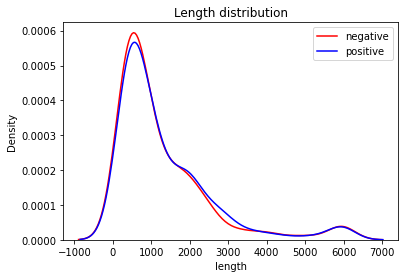

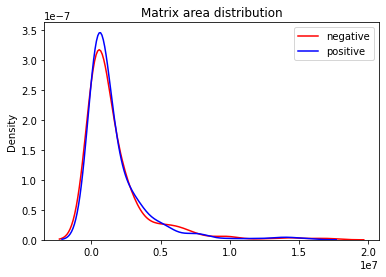

In [13]:
sns.kdeplot(df_len[df_len.label == 'n'].length, color = 'red', label = 'negative')
sns.kdeplot(df_len[df_len.label == 'p'].length, color = 'blue', label = 'positive')
plt.title(f'Length distribution')
plt.legend()
plt.show()
sns.kdeplot(matrix_area_neg, color = 'red', label = 'negative')
sns.kdeplot(matrix_area_pos, color = 'blue', label = 'positive')
plt.title(f'Matrix area distribution')
plt.legend()
plt.show()